# 01. Node classification

![images/009.png](images/009.png)

![images/010.png](images/010.png)

# 02. Node Embeddings with TransE

![images/011.png](images/011.png)

![images/012.png](images/012.png)

![images/013.png](images/013.png)

![images/014.png](images/014.png)

![images/015.png](images/015.png)

- [x] Relational Classication
- [ ] Belief Propagation
- [ ] Warmup: Why the Comparative Loss?
- [ ] The Purpose of the Margin
- [ ] Why are Entity Embeddings Normalized?
- [ ] Where TransE fails

In [1]:
import snap
import numpy as np
import wget
import os
import gzip
from graphviz import Graph
from graphviz import Source
import matplotlib.pyplot as plt

In [2]:
def gz_data_loader(data_url):
    file_to_load = wget.download(data_url)
    filename = os.path.splitext(os.path.basename(data_url))[0]
    os.replace(file_to_load, os.path.join('input', file_to_load))

    with gzip.open(os.path.join('input', file_to_load), 'rb') as f:
        f_in = f.read()
        with open(os.path.join('input', filename), 'wb') as f_out:
            f_out.write(f_in)
            print('\n{} loaded and unpacked'.format(os.path.basename(data_url)))

In [3]:
import hw2

## Relational Classication

In [4]:
G = snap.TUNGraph.New()
for n in range(1, 11):
    G.AddNode(n)
G.AddEdge(1, 2)
G.AddEdge(1, 3)
G.AddEdge(2, 3)
G.AddEdge(2, 4)
G.AddEdge(4, 7)
G.AddEdge(7, 8)
G.AddEdge(4, 8)
G.AddEdge(8, 5)
G.AddEdge(8, 9)
G.AddEdge(3, 6)
G.AddEdge(6, 5)
G.AddEdge(6, 9)
G.AddEdge(9, 5)
G.AddEdge(6, 10)
G.AddEdge(10, 9)

-1

In [5]:
snap.DrawGViz(G, snap.gvlNeato, "images/HW2RelationalClassication.png", "HW2RelationalClassication", True)

![images/HW2RelationalClassication.png](images/HW2RelationalClassication.png)

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [135]:
G1 = nx.Graph()
edges = [(1, 2), (1, 3), (2, 3), (2, 4), (4, 7), (7, 8), (4, 8), (8, 5), (8, 9), (3, 6), (3, 6), (6, 5), 
        (6, 9), (9, 5), (6, 10), (10, 9)]
G1.add_edges_from(edges)
for i in (3, 5):
    G1.nodes[i]['weight'] = 1
for i in (8, 10):
    G1.nodes[i]['weight'] = 0
for i in (1, 2, 4, 6, 7, 9):
    G1.nodes[i]['weight'] = 0.5

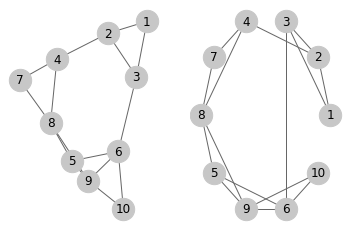

In [54]:
plt.subplot(121)
nx.draw(G1, node_size=500, node_color='#c7c7c7', edge_color='#666666', with_labels=True)
plt.subplot(122)
nx.draw(G1, pos=nx.circular_layout(G1), node_size=500, node_color='#c7c7c7', edge_color='#666666', with_labels=True)

In [136]:
G1.nodes(data=True)

NodeDataView({1: {'weight': 0.5}, 2: {'weight': 0.5}, 3: {'weight': 1}, 4: {'weight': 0.5}, 7: {'weight': 0.5}, 8: {'weight': 0}, 5: {'weight': 1}, 9: {'weight': 0.5}, 6: {'weight': 0.5}, 10: {'weight': 0}})

In [137]:
def prob_pred(N, Graph):
    for n in list(range(N)):
        for i in list(range(10)):
            neighbors = list(nx.neighbors(Graph, i+1))
            n_p = 0
            e_weight = 1
            for j in neighbors:
                n_p += Graph.nodes[j]['weight'] * e_weight
            p = n_p / len(neighbors)
            Graph.nodes[i+1]['weight'] = p
    return Graph

In [142]:
G_p = prob_pred(2, G1.copy())

In [143]:
G_p.nodes(data=True)

NodeDataView({1: {'weight': 0.7083333333333333}, 2: {'weight': 0.5972222222222222}, 3: {'weight': 0.5601851851851851}, 4: {'weight': 0.3900462962962963}, 7: {'weight': 0.37731481481481477}, 8: {'weight': 0.3428819444444444}, 5: {'weight': 0.3359375}, 9: {'weight': 0.3429814091435185}, 6: {'weight': 0.3714916087962962}, 10: {'weight': 0.35723650896990733}})

In [144]:
for i in (2, 4, 6):
    G_p.nodes[i]['weight'] = 1

In [145]:
G_p.nodes(data=True)

NodeDataView({1: {'weight': 0.7083333333333333}, 2: {'weight': 1}, 3: {'weight': 0.5601851851851851}, 4: {'weight': 1}, 7: {'weight': 0.37731481481481477}, 8: {'weight': 0.3428819444444444}, 5: {'weight': 0.3359375}, 9: {'weight': 0.3429814091435185}, 6: {'weight': 1}, 10: {'weight': 0.35723650896990733}})

In [146]:
G_p1 = prob_pred(2, G_p.copy())

In [147]:
G_p1.nodes(data=True)

NodeDataView({1: {'weight': 0.8167438271604939}, 2: {'weight': 0.723411779835391}, 3: {'weight': 0.6896824882517789}, 4: {'weight': 0.5338437848293895}, 7: {'weight': 0.49523708097565156}, 8: {'weight': 0.4981231689453124}, 5: {'weight': 0.48723351121439357}, 9: {'weight': 0.5066997756356237}, 6: {'weight': 0.5389073441221552}, 10: {'weight': 0.5228035598788895}})

In [153]:
[i[0] for i in G_p.nodes(data=True) if i[1]['weight'] > 0.5]

[1, 2, 3, 4, 6]

In [154]:
[i[0] for i in G_p1.nodes(data=True) if i[1]['weight'] > 0.5]

[1, 2, 3, 4, 9, 6, 10]